### 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager
%matplotlib inline

from sklearn.naive_bayes import MultinomialNB

In [2]:
columns = ['userId','movieId','rating']
ratings = pd.read_csv('ratings.csv', usecols = columns)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 2. Exploring dataset

In [3]:
print('Total number of USERS in the data : ',len(ratings['userId'].unique()))
print('Total number of unique MOVIES in the data : ',len(ratings['movieId'].unique()))

Total number of USERS in the data :  610
Total number of unique MOVIES in the data :  9724


### Using pivot method to get data on ratings for each movie by each user

In [4]:
df = ratings.pivot(index='userId',columns='movieId',values='rating')
df = df.reset_index().rename_axis(None, axis=1)
df.set_index('userId', inplace=True)
df

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploring the ratings for null values and ratings distribution

In [5]:
ranks = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
counts ={}
for column in df.columns:
    freq = df[column].value_counts()
    for i in freq.axes[0]:
        if i not in counts.keys():
            counts[i]=freq[i]
        else:
            counts[i]=counts[i]+freq[i]          
dict1 = OrderedDict(sorted(counts.items()))

Text(0.5, 0, 'Ratings (Number of stars)')

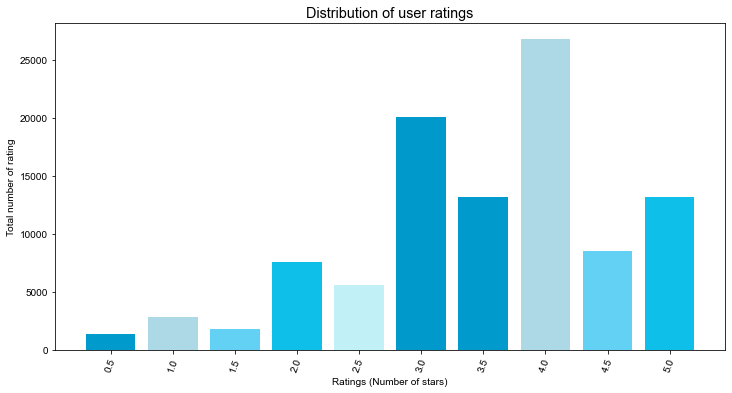

In [6]:
fig, ax = plt.subplots(figsize = (12,6))
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
#color_palette_list = ['#C0392B','#E74C3C', '#2980B9', '#3498DB', '#1ABC9C', '#16A085']
#color_palette_list = ['#5DADE2','#3498DB','#2874A6']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
ind = np.arange(len(dict1.keys()))
bars1 = ax.bar(ind, dict1.values(), 
        color = color_palette_list, 
        label='Number of users')
ax.set_title("Distribution of user ratings")
ax.set_ylabel("Total number of rating")
ax.set_xticks(range(0,len(ind)))
ax.set_xticklabels(dict1.keys(), rotation=70)
ax.set_xlabel("Ratings (Number of stars)")

In [7]:
# total null values
df.isna().sum().sum() 

5830804

### Extracting top 10 movies for which majority of users have voted
#### We will use the movie ID with highest votings as a target movie for our recommender model

In [8]:
s = df.notna().sum().nlargest(10)

<AxesSubplot:>

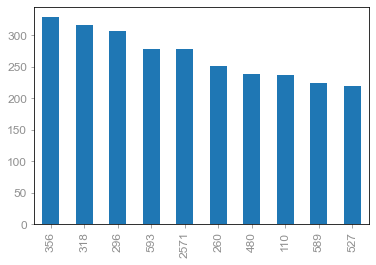

In [9]:
s.plot(kind='bar')

In [10]:
#dropping rows with null values for the tomp movie ID
df.dropna(subset=[356],inplace=True)
df = df.replace(np.nan,0)
df.shape

(329, 9724)

### 3. Defining feature matrix, X and target vector, Y

In [11]:
#movie ID with highest votings will be used for recommendation prediction
Y = df[356]

In [12]:
Y.value_counts().sort_index()

0.5      1
1.0      1
2.0      9
2.5      3
3.0     39
3.5     27
4.0     94
4.5     39
5.0    116
Name: 356, dtype: int64

### The output needs to be yes, if the movie is recommended and no, if it's not recommended. 
#### We can consider movies with ratings greater than 3 as being liked (being recommended). Lets label the target movie ratings into two classes of recommended (for rating more than 3) and not recommended (for rating less than or equal to 3)

In [13]:
Y=Y.where(Y>3,0)
Y=Y.mask(Y>3,1)

In [14]:
Y.value_counts()

1.0    276
0.0     53
Name: 356, dtype: int64

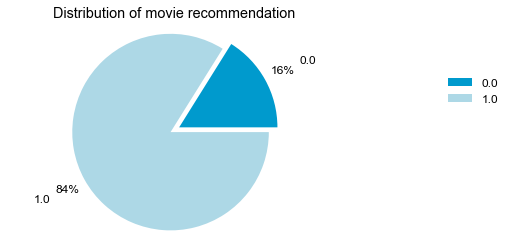

In [15]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = Y.value_counts(ascending=True).index
percentages = Y.value_counts(ascending=True).values
explode=(0.1,0)
ax.pie(percentages, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       explode=explode,
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Distribution of movie recommendation")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

In [16]:
# Defining feature matrix with list of movies and their ratings
X = df.copy()
del X[356]  #deleting the target feature for which we want to predict recommendation
X.shape

(329, 9723)

### 4. Developing model based on naive bayes algorithm using MultinomialNB module of Scikit learn
**We are using MultinomialNB instead of BernoulliNB as our input values range from 0 to 5.**

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
print(len(Y_train), len(Y_test))

263 66


In [19]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)
prediction_prob = clf.predict_proba(X_test)
prediction_prob[:10]

array([[2.51868335e-058, 1.00000000e+000],
       [9.41466882e-045, 1.00000000e+000],
       [2.53204669e-102, 1.00000000e+000],
       [6.89190503e-013, 1.00000000e+000],
       [5.31573361e-014, 1.00000000e+000],
       [7.35832927e-001, 2.64167073e-001],
       [2.60342830e-023, 1.00000000e+000],
       [4.47896831e-114, 1.00000000e+000],
       [3.25736320e-036, 1.00000000e+000],
       [1.55745365e-059, 1.00000000e+000]])

In [20]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]


In [21]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 78.8%
